In [ ]:
# reference: 
#   https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a
#   https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424




In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm


from PIL import Image, ImageDraw
import glob
import os
import matplotlib.pyplot as plt

import numpy as np
import scipy.misc as smp

import json
from datetime import datetime

from operator import add
import re

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error


In [4]:
def rmsle(y_test, predictions):
    return np.sqrt(mean_squared_log_error( y_test, predictions ))

In [5]:
# include functions 
%run phase02-mask-generation/SugarUtils.py

./tiles/tile-x7620-y7600.png
./geometries/geo-x7620-y7600.geojson
./mask/mask-x7620-y7600.png


In [6]:
# tilefile = GetTileName(7620,7600)
# file_pref = 'Phase02-DataDelivery/sugarcanetiles/'

In [7]:
mask_files = f"./Phase02-DataDelivery/masks/*.png"
mask_images = glob.glob(mask_files)

In [8]:
# print(mask_images)

In [9]:
# get all the x, y positions of tiles from masks file name
xy_pair = []
for mask_img in mask_images:
    mask_list = re.findall(r'\d+', mask_img)
    xy_pair.append( (mask_list[1],mask_list[2]) )
    

In [10]:
print(len(xy_pair))
xy_pair[0]

65


('6144', '5120')

In [11]:
# get mask png data
tile_x, tile_y = xy_pair[0][0], xy_pair[0][1]
mask_file_path = f"./Phase02-DataDelivery/masks/mask-x{tile_x}-y{tile_y}.png"
img = Image.open(mask_file_path)
pixels = img.load()

print(img.size)


# why is alpha 255?  alpha range from 0 to 255 (also range from 0 to 1)
# 0 being completely transparent, 255 being completely opaque
# (0,0,0,255) means black

def get_mask_list(pixels):
    mask_list = []

    for x in range(0,512):
        for y in range(0,512):
            if pixels[y,x] == (0,0,0,255):
                mask_list.append((y,x))
    return mask_list



(512, 512)


In [12]:
mask_list = get_mask_list(pixels)
len(mask_list)

175950

In [13]:
def get_timeseries_image_paths(tile_x, tile_y, band):
    path = f"./Phase02-DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-{band}*.png"
    images = glob.glob(path)
    return images

In [14]:
tile_x = xy_pair[0][0]
tile_y = xy_pair[0][1]
band_img = get_timeseries_image_paths(tile_x, tile_y, "TCI")

In [15]:
len(band_img)

71

In [16]:
band_img[0][-14:][:10]

'2018-07-05'

In [17]:
# need to sort the band_img list
# sort the image path according to timeseries

def get_image_path_dict(band_img):
    image_path_dict = {}
    for bi in band_img:
        timestr = bi[-14:][:10]
        t = datetime.strptime(timestr, '%Y-%m-%d')
        image_path_dict[t] = bi
    return image_path_dict

In [18]:
# get time series for TCI
timeseries_list = []
for bi in band_img:
    timestr = bi[52:62]
    timeseries_list.append(timestr)

# sorted timeseries_list
timeseries_list.sort(key = lambda date: datetime.strptime(date, '%Y-%m-%d'))

In [19]:
# store sugacrane pixel to tci_list
def get_sugarcrane_region_from_tci(mask_list, band_pixels):
    tci_list = []

    for mask_ind in mask_list:
        y = mask_ind[0]
        x = mask_ind[1]

        tci_list.append(band_pixels[y,x])
    return tci_list



In [20]:
# store sugacrane pixel to tci_list, then store all the tci images to tci_dict, 
# key is timestamp, value is tci_list

def get_tci_dict(image_path_dict, mask_list):
    tci_dict = {}
    cnt = 0
    for elem in sorted(image_path_dict.keys()):
    #     mask_list = 

        path = image_path_dict[elem]
        img = Image.open(path)
        band_pixels = img.load()

        tci_list = get_sugarcrane_region_from_tci(mask_list, band_pixels)
        tci_dict[cnt] = tci_list
        cnt += 1
    return tci_dict
    

In [45]:
# i range from 0 - 184675
# i represent which pixel on mask image, that is a sugacrane pixel
def which_pixel_over_timeseries(i, tci_dict):
    red_list = []
    green_list = []
    blue_list = []
    for key, value in tci_dict.items():
        color = value[i]      # this is the ith pixel 
        red_list.append(color[0])
        green_list.append(color[1])
        blue_list.append(color[2])
    
    return {"red_list":red_list, "green_list":green_list,"blue_list":blue_list}

def which_pixel_over_timeseries_ndvi(i, dict1):
    res = []
    for key, value in dict1.items():
        num = value[i]      # this is the ith pixel 
        res.append(num)
    
    return res

In [22]:
# for identifying cloud
def is_white_pixel(r,g,b):
    if r >= 225 and g >= 225 and b >= 225:
        return True
    return False

In [23]:
# for identifying cloud
def is_blue_pixel(r,g,b):
    total = r + g + b
    if b > 180 and b / total > 0.35:
        return True
    return False

In [24]:
# this function needs more modifications !!!!!

def is_green_pixel(r,g,b):
    total = r + g + b
    if total == 0:
        return False
    if g / total > 0.33334:
        return True
    return False

In [19]:
# output csv for futher processing 

# 71 days in total 
# for each day, need to calculate total pixel number that are green - total sugacrane area 

green_sum = [0] * 71

for i in tqdm(range(0, len(mask_list))):
    # run over 184676 mask pixels 
    
    color_dict = which_pixel_over_timeseries(i, tci_dict)
    red_list = color_dict["red_list"]    # len = 71
    green_list = color_dict["green_list"]
    blue_list = color_dict["blue_list"]
    
    # if encounter cloud, then use adjacent color. (the previous image or the next image)
    cloud_list = []
    for j in range(0,71):
        r = red_list[j]
        g = green_list[j]
        b = blue_list[j]
        if is_white_pixel(r,g,b) or is_blue_pixel(r,g,b):
            cloud_list.append(j)
    
    for key,value in color_dict.items():
        for k in cloud_list:
            if k == 0:
                kk = k + 1
                while kk in cloud_list:
                    kk += 1
                    if kk == len(value):
                        break
                value[k] = value[kk]
            else:
                kk = k - 1
                while kk in cloud_list:
                    kk -= 1
                    if kk == 0:
                        break
                value[k] = value[kk]
    
    # len(red_list) should be still 71
    red_list = color_dict["red_list"]
    green_list = color_dict["green_list"]
    blue_list = color_dict["blue_list"]
    
    l = 71
    glist = [0] * l
    for h in range(0, l):
        r = red_list[h]
        g = green_list[h]
        b = blue_list[h]

        if is_green_pixel(r,g,b):
            glist[h] = 1
    
    green_sum = list( map(add, green_sum, glist) )
    

NameError: name 'tci_dict' is not defined

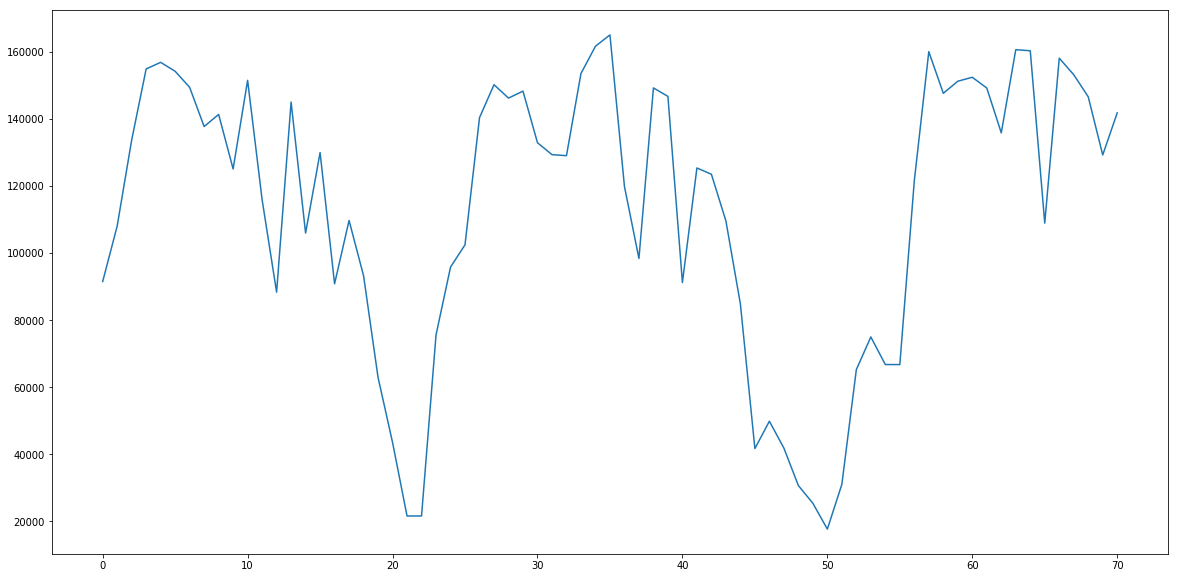

In [46]:
# for a specifix x, y position tile
# total sugacrane pixel number VS. days

plt.figure(figsize=(20,10))
x = range(0,71)
plt.plot(x,green_sum)
plt.show()

In [52]:
tile_id = ["x{}-y{}".format(tile_x,tile_y)] * 71
# tile_id

In [101]:
# df1 = pd.DataFrame({ "tile_id":tile_id, "shot":x, "green_pix_sum":green_sum })
df1 = pd.DataFrame({ "tile_id":[0]*71, "shot":x, "green_pix_sum":green_sum })

In [102]:
df1.head()

,tile_id,shot,green_pix_sum
0,0,0,91481
1,0,1,108012
2,0,2,133676
3,0,3,154892
4,0,4,156853


In [68]:
108012 - 91481

16531

In [59]:
class ToSupervised(BaseEstimator, TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_Shot_Ago'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].shift(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        
            
        return tmp

In [62]:
class ToSupervisedDiff(BaseEstimator,TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_Shot_Ago_Diff_'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].diff(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

In [66]:
steps = [('1_step', ToSupervised('green_pix_sum','tile_id',1)),
         ('1_step_diff', ToSupervisedDiff('1_Shot_Ago_green_pix_sum', 'tile_id', 1 ,dropna=True))
        ]

super_df1 = Pipeline(steps).fit_transform(df1)

In [97]:
print( super_df1.shape )
# super_df1.head() 
super_df1.tail() 
# super_df1.info()

(69, 5)


,tile_id,shot,green_pix_sum,1_Shot_Ago_green_pix_sum,1_Shot_Ago_Diff__1_Shot_Ago_green_pix_sum
64,x6144-y5120,66,158092,108894.0,-51418.0
65,x6144-y5120,67,153165,158092.0,49198.0
66,x6144-y5120,68,146580,153165.0,-4927.0
67,x6144-y5120,69,129222,146580.0,-6585.0
68,x6144-y5120,70,141792,129222.0,-17358.0


In [82]:
class TimeSeriesRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring 
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):
            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction
    def score(self,X,y=None):
        errors = []
        for indx,fold in enumerate(self.cv.split(X)):
            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.scoring(y_test, prediction)
            errors.append(error)
            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))
         
        if self.verbosity:
            print('Total Error {:.4f}'.format(np.mean(errors)))
        return errors

In [76]:
from itertools import chain
class Kfold_time(object):
    
    def __init__(self,**options):
        
        
        self.target     = options.pop('target', None)
        self.date_col   = options.pop('date_col', None)
        self.date_init  = options.pop('date_init', None)
        self.date_final = options.pop('date_final', None)
        if options:
            raise TypeError("Invalid parameters passed: %s" %
                               str(options))
            
        if ((self.target==None )|(self.date_col==None )|
            (self.date_init==None )|(self.date_final==None )):
             
            raise TypeError("Incomplete inputs")
    
    def _train_test_split_time(self,X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")
        for i in range(self.date_init,self.date_final):
            train = X[X[self.date_col] < i]
            val   = X[X[self.date_col] == i]
            X_train, X_test = train.drop([self.target], axis=1), val.drop([self.target], axis=1)
            y_train, y_test = train[self.target].values, val[self.target].values
            yield X_train, X_test, y_train, y_test
    def split(self,X):
        cv_t = self._train_test_split_time(X)
        return chain(cv_t)

In [98]:
kf = Kfold_time(target='green_pix_sum', date_col = 'shot', date_init=60, date_final=70)


In [108]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

steps_1 = [
           ('1_step', ToSupervised('green_pix_sum','tile_id',1)),
           ('1_step_diff', ToSupervisedDiff('1_Shot_Ago_green_pix_sum', 'tile_id', 1, dropna=True)),
           ('predic_1', TimeSeriesRegressor(model=model, cv=kf, scoring=rmsle))
          ]

super_1_p = Pipeline(steps_1).fit(df1)
# Model_1_Error = super_1_p.score(df1)

In [109]:
# type(super_1_p)
Model_1_Error = super_1_p.score(df1)

Fold: 0, Error: 0.1370
Fold: 1, Error: 0.0447
Fold: 2, Error: 0.0321
Fold: 3, Error: 0.1961
Fold: 4, Error: 0.0655
Fold: 5, Error: 0.3235
Fold: 6, Error: 0.3531
Fold: 7, Error: 0.1204
Fold: 8, Error: 0.0447
Fold: 9, Error: 0.0803
Total Error 0.1398


In [119]:
# add more lags
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0, max_depth=8)
steps_3 = [
           ('1_step', ToSupervised('green_pix_sum','tile_id',3)),
           ('1_step_diff', ToSupervisedDiff('1_Shot_Ago_green_pix_sum', 'tile_id', 1)),
           ('2_step_diff', ToSupervisedDiff('2_Shot_Ago_green_pix_sum', 'tile_id', 1)),
           ('3_step_diff', ToSupervisedDiff('3_Shot_Ago_green_pix_sum', 'tile_id', 1, dropna=True)),
           ('predic_3', TimeSeriesRegressor(model=model,cv=kf,scoring=rmsle))
          ]
super_3_p = Pipeline(steps_3).fit(df1)
Model_2_Error = super_3_p.score(df1)

Fold: 0, Error: 0.1898
Fold: 1, Error: 0.0977
Fold: 2, Error: 0.0311
Fold: 3, Error: 0.1753
Fold: 4, Error: 0.1320
Fold: 5, Error: 0.3250
Fold: 6, Error: 0.3241
Fold: 7, Error: 0.0967
Fold: 8, Error: 0.1977
Fold: 9, Error: 0.1227
Total Error 0.1692


In [120]:
# import math
# # np.sqrt((600-1000)**2)
# math.log(50221290/61007022)

In [54]:
# building all data dataframe 



# output csv for futher processing 

# 71 days in total 
# for each day, need to calculate total pixel number that are green - total sugacrane area 

tile_xy_dict = {}
for xy in tqdm( xy_pair ):
    # get mask png data
    tile_x, tile_y = xy[0], xy[1]
    mask_file_path = f"./Phase02-DataDelivery/masks/mask-x{tile_x}-y{tile_y}.png"
    img = Image.open(mask_file_path)
    pixels = img.load()
    
    mask_list = get_mask_list(pixels)

    # get tci_dict
    band_img = get_timeseries_image_paths(tile_x, tile_y, "TCI")
    image_path_dict = get_image_path_dict(band_img)
    tci_dict = get_tci_dict(image_path_dict, mask_list)
    
    # for ndvi analysis 
    band_img_RED = get_timeseries_image_paths(tile_x, tile_y, "B04")
    image_path_dict_RED = get_image_path_dict(band_img_RED)
    red_dict = get_tci_dict(image_path_dict_RED, mask_list)

    band_img_NIR = get_timeseries_image_paths(tile_x, tile_y, "B08")
    image_path_dict_NIR = get_image_path_dict(band_img_NIR)
    nir_dict = get_tci_dict(image_path_dict_NIR, mask_list)
    
    # get the rest of the band 
    band_img_BLUE = get_timeseries_image_paths(tile_x, tile_y, "B02")
    image_path_dict_BLUE = get_image_path_dict(band_img_BLUE)
    blue_dict = get_tci_dict(image_path_dict_BLUE, mask_list)
    
    band_img_GREEN = get_timeseries_image_paths(tile_x, tile_y, "B03")
    image_path_dict_GREEN = get_image_path_dict(band_img_GREEN)
    green_dict = get_tci_dict(image_path_dict_GREEN, mask_list)
    
    band_img_VRE1 = get_timeseries_image_paths(tile_x, tile_y, "B05")
    image_path_dict_VRE1 = get_image_path_dict(band_img_VRE1)
    vre1_dict = get_tci_dict(image_path_dict_VRE1, mask_list)
    
    band_img_VRE2 = get_timeseries_image_paths(tile_x, tile_y, "B06")
    image_path_dict_VRE2 = get_image_path_dict(band_img_VRE2)
    vre2_dict = get_tci_dict(image_path_dict_VRE2, mask_list)
    
    band_img_VRE3 = get_timeseries_image_paths(tile_x, tile_y, "B07")
    image_path_dict_VRE3 = get_image_path_dict(band_img_VRE3)
    vre3_dict = get_tci_dict(image_path_dict_VRE3, mask_list)
    

#     green_sum = [0] * 71

#     ndvi_list = []
    tile_dict = {}

    for i in tqdm(range(0, len(mask_list))):
        # run over 184676 mask pixels 

        color_dict = which_pixel_over_timeseries(i, tci_dict)
        tci_red_list = color_dict["red_list"]    # len = 71
        tci_green_list = color_dict["green_list"]
        tci_blue_list = color_dict["blue_list"]

        # if encounter cloud, then use adjacent color. (the previous image or the next image)
        cloud_list = []
        for j in range(0,71):
            r = tci_red_list[j]
            g = tci_green_list[j]
            b = tci_blue_list[j]
            if is_white_pixel(r,g,b) or is_blue_pixel(r,g,b):
                cloud_list.append(j)

#         for key,value in color_dict.items():

        # calculate the ndvi value for that one particular pixel 
        nir_list = which_pixel_over_timeseries_ndvi(i, nir_dict)
        red_list = which_pixel_over_timeseries_ndvi(i, red_dict)
        blue_list = which_pixel_over_timeseries_ndvi(i, blue_dict)
        green_list = which_pixel_over_timeseries_ndvi(i, green_dict)
        vre1_list = which_pixel_over_timeseries_ndvi(i, vre1_dict)
        vre2_list = which_pixel_over_timeseries_ndvi(i, vre2_dict)
        vre3_list = which_pixel_over_timeseries_ndvi(i, vre3_dict)
        
        for k in cloud_list:
            if k == 0:
                kk = k + 1
                while kk in cloud_list:
                    kk += 1
                    if kk == len(value):
                        break
#                 value[k] = value[kk]
                nir_list[k] = nir_list[kk]
                red_list[k] = red_list[kk]
                blue_list[k] = blue_list[kk]
                green_list[k] = green_list[kk]
                vre1_list[k] = vre1_list[kk]
                vre2_list[k] = vre2_list[kk]
                vre3_list[k] = vre3_list[kk]
            else:
                kk = k - 1
                while kk in cloud_list:
                    kk -= 1
                    if kk == 0:
                        break
#                 value[k] = value[kk]
                nir_list[k] = nir_list[kk]
                red_list[k] = red_list[kk]
                blue_list[k] = blue_list[kk]
                green_list[k] = green_list[kk]
                vre1_list[k] = vre1_list[kk]
                vre2_list[k] = vre2_list[kk]
                vre3_list[k] = vre3_list[kk]
        
        tile_dict[i] = { 
            "nir_list" : nir_list,
            "red_list" : red_list,
            "blue_list" : blue_list,
            "green_list" : green_list,
            "vre1_list" : vre1_list,
            "vre2_list" : vre2_list,
            "vre3_list" : vre3_list
        }
#         nir_arr = np.array( nir_list )
#         red_arr = np.array( red_list )

#         ndvi_array = np.divide( np.subtract(nir_arr, red_arr), np.add(nir_arr, red_arr) )
#         ndvi_list.append( ndvi_array.tolist() )
        
    
        # len(red_list) should be still 71
#         red_list = color_dict["red_list"]
#         green_list = color_dict["green_list"]
#         blue_list = color_dict["blue_list"]

        

#         l = 71
#         glist = [0] * l
#         for h in range(0, l):
#             r = red_list[h]
#             g = green_list[h]
#             b = blue_list[h]

#             if is_green_pixel(r,g,b):
#                 glist[h] = 1

#         green_sum = list( map(add, green_sum, glist) )
    
    dictkey = "x{}-y{}".format(tile_x,tile_y)
#     tile_xy_dict[dictkey] = green_sum
#     res_ndvi = np.mean(np.array(ndvi_list), axis=0)
#     print(res_ndvi)
#     break
#     tile_xy_dict[dictkey] = res_ndvi.tolist()
    tile_xy_dict[dictkey] = tile_dict
    break


In [59]:
timeseries_list[37]

'2018-05-26'

In [60]:
len(tile_dict)
res = []
for k, v in tqdm( tile_dict.items() ):   # a total of 175950 pixels
    l = []
    for kk, vv in v.items():    # a total of 7 faetures
        l.append(vv[37])
    res.append(l)

In [63]:
df1 = pd.DataFrame(res, columns = ["nir", "red", "blue", "green", "vre1", "vre2", "vre3"])
df1.head()

,nir,red,blue,green,vre1,vre2,vre3
0,6146,1594,2512,2254,2318,4556,5816
1,5490,1692,2452,2192,2318,4556,5816
2,5546,1704,2484,2204,2446,4724,5690
3,5658,1694,2494,2218,2446,4724,5690
4,5558,1776,2462,2280,2544,4854,5914


In [64]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175950 entries, 0 to 175949
Data columns (total 7 columns):
nir      175950 non-null int64
red      175950 non-null int64
blue     175950 non-null int64
green    175950 non-null int64
vre1     175950 non-null int64
vre2     175950 non-null int64
vre3     175950 non-null int64
dtypes: int64(7)
memory usage: 9.4 MB


In [76]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=13, random_state=0, verbose=True, n_jobs=-1, tol=1e-5, max_iter=900)
X = df1.values
kmeans.fit(X)


Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 216542720323.10706
start iteration
done sorting
end inner loop
Iteration 1, inertia 199762288144.4158
start iteration
done sorting
end inner loop
Iteration 2, inertia 195883922034.34985
start iteration
done sorting
end inner loop
Iteration 3, inertia 194639968151.3277
start iteration
done sorting
end inner loop
Iteration 4, inertia 194100106758.9026
start iteration
done sorting
end inner loop
Iteration 5, inertia 193737392773.6388
start iteration
done sorting
end inner loop
Iteration 6, inertia 193433069749.23422
start iteration
done sorting
end inner loop
Iteration 7, inertia 193144062207.53107
start iteration
done sorting
end inner loop
Iteration 8, inertia 192836564954.45712
start iteration
done sorting
end inner loop
Iteration 9, inertia 192464730819.59332
start iteration
done sorting
end inner loop
Iteration 10, inertia 192042070876.11835
start iteration
done sorting
end inner loop
Iteration 1

Iteration 19, inertia 190779271197.68347
start iteration
done sorting
end inner loop
Iteration 20, inertia 190775254268.28113
start iteration
done sorting
end inner loop
Iteration 21, inertia 190772639226.8734
start iteration
done sorting
end inner loop
Iteration 22, inertia 190771094154.72073
start iteration
done sorting
end inner loop
Iteration 23, inertia 190770005376.07184
start iteration
done sorting
end inner loop
Iteration 24, inertia 190769148124.4173
start iteration
done sorting
end inner loop
Iteration 25, inertia 190768495389.63876
start iteration
done sorting
end inner loop
Iteration 26, inertia 190768129838.1356
start iteration
done sorting
end inner loop
Iteration 27, inertia 190767790484.99744
start iteration
done sorting
end inner loop
Iteration 28, inertia 190767512452.37268
start iteration
done sorting
end inner loop
Iteration 29, inertia 190767253524.85797
start iteration
done sorting
end inner loop
Iteration 30, inertia 190767111010.73178
start iteration
done sortin

done sorting
end inner loop
Iteration 87, inertia 191338411443.84912
start iteration
done sorting
end inner loop
Iteration 88, inertia 191329496892.57248
start iteration
done sorting
end inner loop
Iteration 89, inertia 191319976599.0078
start iteration
done sorting
end inner loop
Iteration 90, inertia 191310065413.4109
start iteration
done sorting
end inner loop
Iteration 91, inertia 191299752820.6742
start iteration
done sorting
end inner loop
Iteration 92, inertia 191288164213.54852
start iteration
done sorting
end inner loop
Iteration 93, inertia 191274127150.5733
start iteration
done sorting
end inner loop
Iteration 94, inertia 191261393075.68634
start iteration
done sorting
end inner loop
Iteration 95, inertia 191249836218.8152
start iteration
done sorting
end inner loop
Iteration 96, inertia 191237147176.06702
start iteration
done sorting
end inner loop
Iteration 97, inertia 191223643077.0288
start iteration
done sorting
end inner loop
Iteration 98, inertia 191208396972.1353
sta

Iteration 186, inertia 190776032255.33133
start iteration
done sorting
end inner loop
Iteration 187, inertia 190775795136.46765
start iteration
done sorting
end inner loop
Iteration 188, inertia 190775631222.52692
start iteration
done sorting
end inner loop
Iteration 189, inertia 190775370860.4907
start iteration
done sorting
end inner loop
Iteration 190, inertia 190775162735.30063
start iteration
done sorting
end inner loop
Iteration 191, inertia 190775011354.804
start iteration
done sorting
end inner loop
Iteration 192, inertia 190774927683.44058
center shift 4.670981e+00 within tolerance 2.697470e+01
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 217166584014.2216
start iteration
done sorting
end inner loop
Iteration 1, inertia 202641429515.65634
start iteration
done sorting
end inner loop
Iteration 2, inertia 199468462395.3677
start iteration
done sorting
end inner loop
Iteration 3, inertia 198255136644.0202
start iteration
done sorting
end

Iteration 89, inertia 191504959009.83023
start iteration
done sorting
end inner loop
Iteration 90, inertia 191503566686.74146
start iteration
done sorting
end inner loop
Iteration 91, inertia 191501868423.7286
start iteration
done sorting
end inner loop
Iteration 92, inertia 191499773375.65082
start iteration
done sorting
end inner loop
Iteration 93, inertia 191497465495.9832
start iteration
done sorting
end inner loop
Iteration 94, inertia 191494833119.9846
start iteration
done sorting
end inner loop
Iteration 95, inertia 191492212378.02048
start iteration
done sorting
end inner loop
Iteration 96, inertia 191489702761.53973
start iteration
done sorting
end inner loop
Iteration 97, inertia 191486464842.36563
start iteration
done sorting
end inner loop
Iteration 98, inertia 191482323900.76086
start iteration
done sorting
end inner loop
Iteration 99, inertia 191477331375.2392
start iteration
done sorting
end inner loop
Iteration 100, inertia 191471023155.90393
start iteration
done sortin

Iteration 186, inertia 190815849091.7103
start iteration
done sorting
end inner loop
Iteration 187, inertia 190813642194.2085
start iteration
done sorting
end inner loop
Iteration 188, inertia 190812172003.841
start iteration
done sorting
end inner loop
Iteration 189, inertia 190810698055.58484
start iteration
done sorting
end inner loop
Iteration 190, inertia 190809172086.01193
start iteration
done sorting
end inner loop
Iteration 191, inertia 190807857476.3286
start iteration
done sorting
end inner loop
Iteration 192, inertia 190806700314.43942
start iteration
done sorting
end inner loop
Iteration 193, inertia 190805676406.6822
start iteration
done sorting
end inner loop
Iteration 194, inertia 190804849746.57855
start iteration
done sorting
end inner loop
Iteration 195, inertia 190803858520.62646
start iteration
done sorting
end inner loop
Iteration 196, inertia 190802502351.8917
start iteration
done sorting
end inner loop
Iteration 197, inertia 190801326746.09244
start iteration
don

Iteration 62, inertia 188226079965.60623
start iteration
done sorting
end inner loop
Iteration 63, inertia 188225920557.35422
start iteration
done sorting
end inner loop
Iteration 64, inertia 188225843496.34998
center shift 4.960728e+00 within tolerance 2.697470e+01
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 216975776626.11627
start iteration
done sorting
end inner loop
Iteration 1, inertia 206716605748.6203
start iteration
done sorting
end inner loop
Iteration 2, inertia 204089500405.0222
start iteration
done sorting
end inner loop
Iteration 3, inertia 203020787794.33774
start iteration
done sorting
end inner loop
Iteration 4, inertia 202430322129.92096
start iteration
done sorting
end inner loop
Iteration 5, inertia 202065045767.2869
start iteration
done sorting
end inner loop
Iteration 6, inertia 201796378406.72772
start iteration
done sorting
end inner loop
Iteration 7, inertia 201589516927.01263
start iteration
done sorting
end inner l

Iteration 97, inertia 190832517562.1823
start iteration
done sorting
end inner loop
Iteration 98, inertia 190831645761.0206
start iteration
done sorting
end inner loop
Iteration 99, inertia 190830564913.2175
start iteration
done sorting
end inner loop
Iteration 100, inertia 190829439560.24222
start iteration
done sorting
end inner loop
Iteration 101, inertia 190828987404.5585
start iteration
done sorting
end inner loop
Iteration 102, inertia 190828688613.0512
start iteration
done sorting
end inner loop
Iteration 103, inertia 190828309638.84195
start iteration
done sorting
end inner loop
Iteration 104, inertia 190827883594.385
start iteration
done sorting
end inner loop
Iteration 105, inertia 190827512314.86798
start iteration
done sorting
end inner loop
Iteration 106, inertia 190827285842.15994
start iteration
done sorting
end inner loop
Iteration 107, inertia 190827219925.49966
center shift 4.024304e+00 within tolerance 2.697470e+01
Initialization complete
start iteration
done sorting

Iteration 34, inertia 193466447999.02194
start iteration
done sorting
end inner loop
Iteration 35, inertia 193465723165.63498
start iteration
done sorting
end inner loop
Iteration 36, inertia 193465107435.65735
start iteration
done sorting
end inner loop
Iteration 37, inertia 193464652051.80466
start iteration
done sorting
end inner loop
Iteration 38, inertia 193464195022.3937
start iteration
done sorting
end inner loop
Iteration 39, inertia 193463718497.16376
start iteration
done sorting
end inner loop
Iteration 40, inertia 193463092823.89
start iteration
done sorting
end inner loop
Iteration 41, inertia 193462519530.70123
start iteration
done sorting
end inner loop
Iteration 42, inertia 193461971802.44165
start iteration
done sorting
end inner loop
Iteration 43, inertia 193461468632.9814
start iteration
done sorting
end inner loop
Iteration 44, inertia 193461105809.25687
start iteration
done sorting
end inner loop
Iteration 45, inertia 193460746863.8371
start iteration
done sorting
e

Iteration 77, inertia 188225386902.1008
start iteration
done sorting
end inner loop
Iteration 78, inertia 188225267602.26874
start iteration
done sorting
end inner loop
Iteration 79, inertia 188225157103.14108
start iteration
done sorting
end inner loop
Iteration 80, inertia 188225053264.60925
start iteration
done sorting
end inner loop
Iteration 81, inertia 188224933311.12244
start iteration
done sorting
end inner loop
Iteration 82, inertia 188224876128.72562
center shift 4.136780e+00 within tolerance 2.697470e+01
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 212956343371.18445
start iteration
done sorting
end inner loop
Iteration 1, inertia 201955063753.57428
start iteration
done sorting
end inner loop
Iteration 2, inertia 199328805666.10797
start iteration
done sorting
end inner loop
Iteration 3, inertia 198279208124.43158
start iteration
done sorting
end inner loop
Iteration 4, inertia 197674344217.58368
start iteration
done sorting
end in

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=900,
    n_clusters=13, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=1e-05, verbose=True)

In [68]:
type_y = kmeans.labels_
len(type_y)
type_y[:10]

array([12,  0,  0, 12, 12,  3,  3,  3,  3,  3], dtype=int32)

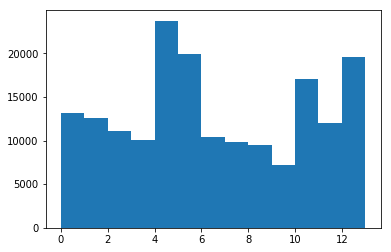

In [77]:
type_y_arr = np.array(type_y)
plt.hist(type_y_arr, bins=np.arange(type_y_arr.min(), type_y_arr.max()+2))
plt.show()


{0: 13167, 1: 12551, 2: 11080, 3: 10096, 4: 23724, 5: 19914, 6: 10385, 7: 9819, 8: 9440, 9: 7147, 10: 17003, 11: 12062, 12: 19562}


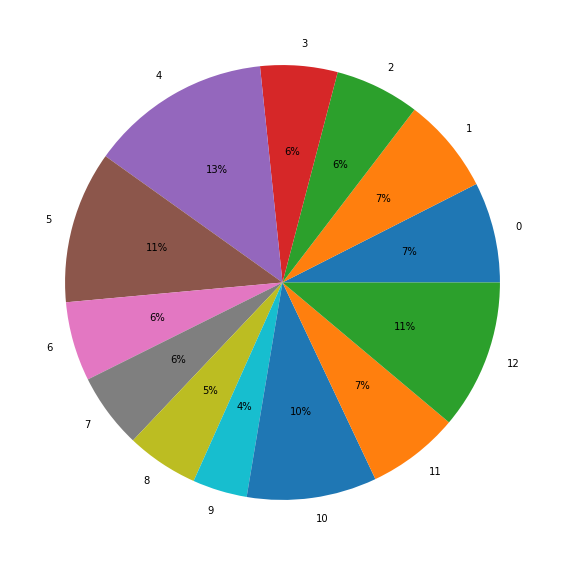

In [78]:
unique, counts = np.unique(type_y_arr, return_counts=True)
d1 = dict(zip(unique, counts))
print(d1)
plt.figure(figsize=(15,10))
plt.pie(counts, labels=unique, autopct='%1.0f%%')
plt.show()

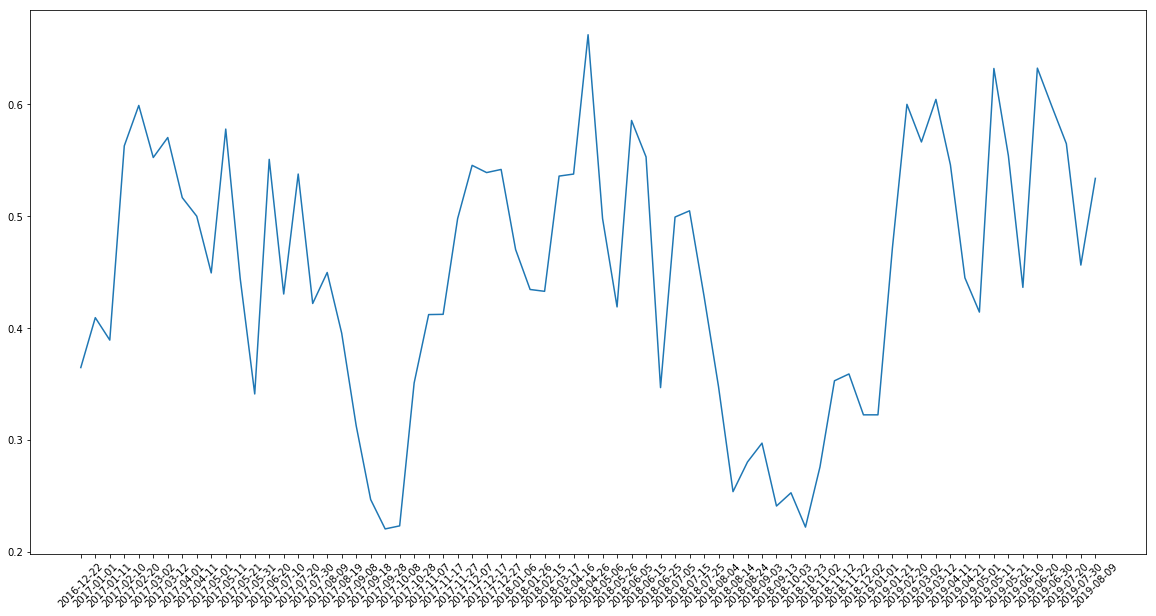

In [49]:
plt.figure(figsize=(20,10))
ty = [0.36449405, 0.4091051,  0.38905678, 0.56266015, 0.59879629, 0.55225677,
 0.57011896, 0.51639871, 0.49976945, 0.44910786, 0.57766078, 0.44393301,
 0.34091683, 0.5506054,  0.43025587, 0.53747546, 0.4217811 , 0.44948023,
 0.3952555,  0.31254579, 0.24653064, 0.22027697, 0.2229998 , 0.35076252,
 0.41186077, 0.41207559 ,0.49764948, 0.54523905, 0.53878539, 0.54158001,
 0.47000698, 0.43428702, 0.43265033, 0.53564879, 0.53745368, 0.66199003,
 0.49768356, 0.41871596, 0.58537431, 0.55279337, 0.34659179, 0.49904288,
 0.50461458, 0.42845201, 0.34746983, 0.25358638, 0.28012791, 0.29695598,
 0.2407368,  0.25257122, 0.22189385, 0.27569509, 0.35268669, 0.35878023,
 0.3222526,  0.32224856, 0.47163506, 0.59977305, 0.56614362, 0.60420844,
 0.54570592, 0.44472113, 0.4140936 , 0.63183585, 0.55380372, 0.43617523,
 0.63213374, 0.5979455,  0.56458904, 0.4561135,  0.53358838]
tx=timeseries_list
plt.plot(tx,ty)
plt.xticks(rotation=45)
plt.show()

In [51]:
import json

# with open("tile_xy_ndvi_dict.json",'w') as fp:
#     json.dump(tile_xy_dict, fp)


In [27]:
with open("tile_xy_dict.json",'r') as fp:
    tile_xy_dict = json.load(fp)

In [34]:
len(tile_xy_dict)   #  65 tiles 
tile_x, tile_y = xy_pair[0][0], xy_pair[0][1]
len( tile_xy_dict["x{}-y{}".format(tile_x,tile_y)] )

71

In [35]:
greensum_df = pd.DataFrame.from_dict(tile_xy_dict)

In [37]:
greensum_df.head(20)

,x6144-y5120,x6144-y7680,x5632-y7168,x4608-y6144,x6656-y6144,x6656-y8192,x5632-y8704,x7168-y10240,x5120-y6656,x2048-y1024,...,x7168-y9728,x6656-y5120,x7168-y4608,x5120-y5632,x7680-y10240,x6144-y4608,x6144-y9728,x5632-y6656,x5632-y4096,x6144-y8192
0,91481,45694,11562,354,2385,26562,8044,76488,14695,403,...,18691,63052,11227,83317,126421,65351,274,1628,23139,33606
1,108012,43616,11467,421,1771,33040,13687,91449,13490,400,...,24951,80812,9367,84475,136551,66444,1311,867,24150,31842
2,133676,55458,15350,507,2152,41573,15207,89387,31188,435,...,25500,78800,10889,132185,133200,75303,1923,1961,33101,45448
3,154892,60923,19151,907,3050,46997,14516,97686,34779,705,...,23281,112460,9661,144192,156598,82406,1583,1911,32881,45411
4,156853,74290,19553,1012,2859,56434,18074,101605,34581,680,...,28694,99304,14485,141616,161063,90527,1880,2061,34145,52453
5,154195,69902,19094,1049,2700,56479,18972,89196,32281,424,...,24063,96185,14266,141615,148648,87152,1904,1985,34279,49947
6,149408,67620,18629,726,2726,54295,18419,92974,33903,522,...,25021,112241,14174,141332,152254,89644,1704,2329,33505,46114
7,137710,68810,18891,677,2892,55860,19297,104724,34165,424,...,29157,104343,14365,142514,160118,90100,1930,2313,33419,51015
8,141324,68671,18828,692,3004,54952,19247,103911,33485,410,...,28994,106202,14036,142431,160406,89348,1930,2297,32648,50675
9,125059,68519,18828,442,3004,53079,11553,103899,25899,161,...,28994,82289,9744,125121,158971,76863,1751,2297,28071,43601


In [41]:
total_greensum_over_all_tiles = greensum_df.sum(axis=1)

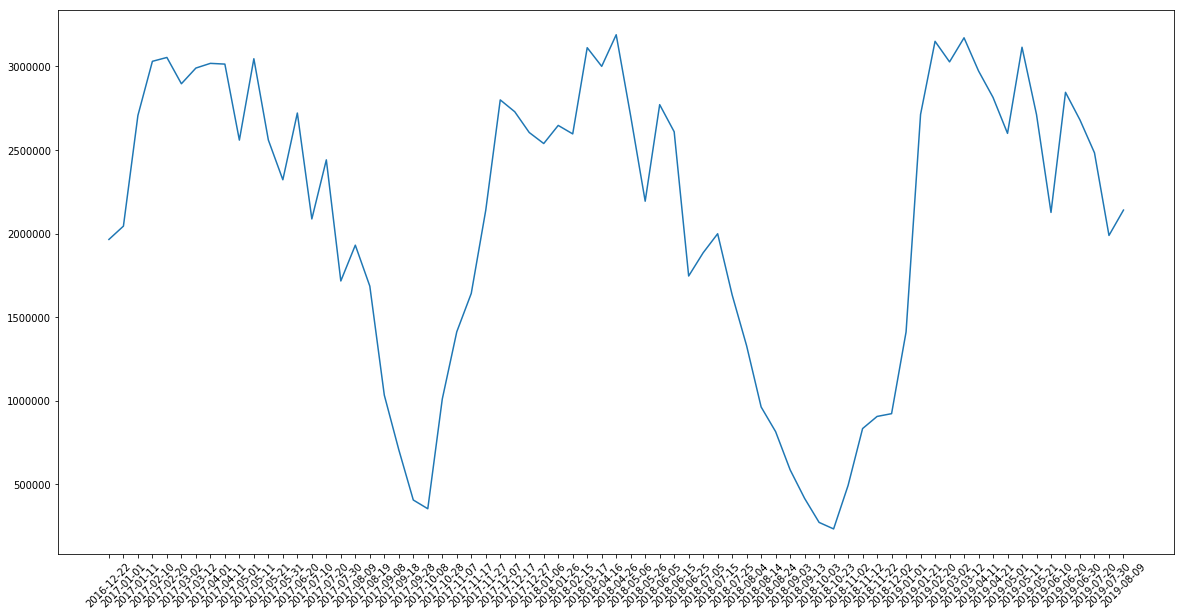

In [44]:
plt.figure(figsize=(20,10))
x = timeseries_list
plt.plot(x,total_greensum_over_all_tiles)
plt.xticks(rotation=45)
plt.show()

In [148]:
cnt = 0
df_list = []
for key,value in tile_xy_dict.items():
    x = list(range(0,71))
    df = pd.DataFrame({ "tile_id":[cnt]*71, "shot":x, "green_pix_sum":value })
    df_list.append(df)
    cnt += 1
total_df = pd.concat(df_list)

In [150]:
# total_df.shape
total_df.head()

,tile_id,shot,green_pix_sum
0,0,0,91481
1,0,1,108012
2,0,2,133676
3,0,3,154892
4,0,4,156853


In [151]:
kf = Kfold_time(target='green_pix_sum', date_col = 'shot', date_init=65, date_final=70)
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0, max_depth=8)
steps_3 = [
           ('1_step', ToSupervised('green_pix_sum','tile_id',3)),
           ('1_step_diff', ToSupervisedDiff('1_Shot_Ago_green_pix_sum', 'tile_id', 1)),
           ('2_step_diff', ToSupervisedDiff('2_Shot_Ago_green_pix_sum', 'tile_id', 1)),
           ('3_step_diff', ToSupervisedDiff('3_Shot_Ago_green_pix_sum', 'tile_id', 1, dropna=True)),
           ('predic_3', TimeSeriesRegressor(model=model,cv=kf,scoring=rmsle))
          ]
super_3_p = Pipeline(steps_3).fit(total_df)
Model_2_Error = super_3_p.score(total_df)

Fold: 0, Error: 0.8336
Fold: 1, Error: 0.5995
Fold: 2, Error: 0.5184
Fold: 3, Error: 0.5400
Fold: 4, Error: 0.6904
Total Error 0.6364
